In [1]:
import fitz  # PyMuPDF
import os

# Load the PDF
pdf_file = "MANGILAL.pdf"
pdf_document = fitz.open(pdf_file)

# Create a directory to save extracted images
os.makedirs("extracted_images", exist_ok=True)

# Extract images from each page
for page_number in range(len(pdf_document)):
    page = pdf_document.load_page(page_number)
    image_list = page.get_images(full=True)
    
    for img_index, img in enumerate(image_list):
        xref = img[0]
        base_image = pdf_document.extract_image(xref)
        image_bytes = base_image["image"]
        image_filename = f"extracted_images/page_{page_number + 1}_img_{img_index + 1}.png"
        
        with open(image_filename, "wb") as image_file:
            image_file.write(image_bytes)

print(f"Extracted {len(os.listdir('extracted_images'))} images from the PDF.")


Extracted 72 images from the PDF.


In [2]:
import cv2
import numpy as np

def preprocess_image(image_path):
    # Read the image
    image = cv2.imread(image_path)
    # Convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Resize image to 128x128 (you can adjust this size based on your dataset)
    image = cv2.resize(image, (128, 128))
    # Normalize pixel values between 0 and 1
    image = image / 255.0
    return image

# Load and preprocess all images
image_folder = "extracted_images"
image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]
processed_images = np.array([preprocess_image(img) for img in image_paths])

# Reshape to add channel dimension (required for CNN input)
processed_images = processed_images.reshape(-1, 128, 128, 1)


In [6]:
# Only keep images that have corresponding labels
image_paths_with_labels = [img for img in image_paths if os.path.basename(img) in labels]

# Process only the images that have labels
processed_images = np.array([preprocess_image(img) for img in image_paths_with_labels])

# Create labels corresponding to these images
y = np.array([labels[os.path.basename(img)] for img in image_paths_with_labels])



In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_images, y, test_size=0.2, random_state=42)



In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Build CNN model
def build_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(4, activation='softmax')  # 4 classes: 0, 90, 180, 270 degrees
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [9]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")


1/1 [==============================] - 0s 62ms/step - loss: 5.9984 - accuracy: 0.0000e+00
Test accuracy: 0.0


1/1 [==============================] - 0s 234ms/step


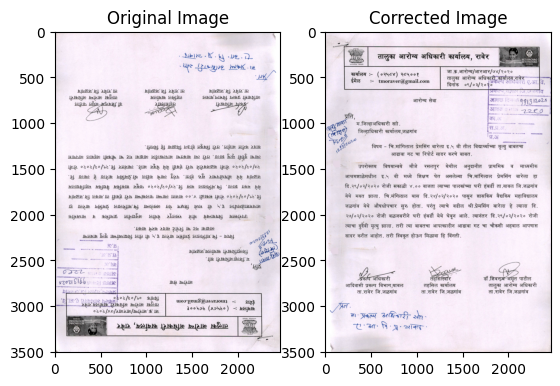

In [10]:
def correct_orientation(image, predicted_label):
    if predicted_label == 1:  # 90 degrees
        return cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    elif predicted_label == 2:  # 180 degrees
        return cv2.rotate(image, cv2.ROTATE_180)
    elif predicted_label == 3:  # 270 degrees
        return cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    return image  # If 0, no need to rotate

# Predict and correct orientation for a sample image
image_path = "extracted_images/page_1_img_1.png"  # Use one of your images
image = preprocess_image(image_path).reshape(1, 128, 128, 1)

# Predict orientation
prediction = model.predict(image)
predicted_label = np.argmax(prediction)

# Load original image (for displaying the corrected image)
original_image = cv2.imread(image_path)

# Correct the orientation based on the prediction
corrected_image = correct_orientation(original_image, predicted_label)

# Display original and corrected images
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Corrected Image")
plt.imshow(cv2.cvtColor(corrected_image, cv2.COLOR_BGR2RGB))

plt.show()


In [11]:
model.save("marathi_text_orientation_model.h5")
